# Select data to use for analysis

Based on the QC reports generated by notebook 03, we've decided to restict
analysis to:

- A subset of kages that passed QC
- A given good week (7-day-period) for each kage
- The most reliable keypoint ("bodycenter")

The QC results are stored as a table in `2024-04-Apr-May-Downs/movement_analysis/QC.tsv`.

In [44]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

## Configuration
Defines plotting styles.

In [2]:
# Configure seaborn for prettier plots
sns.set_context("notebook")
sns.set_style("ticks")

Define paths to the `movement_analysis` directory and the `QC.tsv` file.

In [3]:
project_dir = Path("/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs")
analysis_dir = project_dir / "movement_analysis"
assert analysis_dir.exists(), f"Path does not exist: {analysis_dir}"

qc_file = analysis_dir / "QC.tsv"
assert qc_file.exists(), f"Path does not exist: {qc_file}"

## Load QC results

Let's load the QC results table and parse the dates appropriately.

In [20]:
# Columns containing dates
date_columns = [
    "kage_start_date",
    "good_dates_start",
    "good_dates_end",
    "analysis_start_date",
    "analysis_end_date",
]

# Load QC results
qc_df = pd.read_csv(
    qc_file,
    sep="\t",
    index_col=0,
    parse_dates=date_columns,
)
# Convert "keep" to boolean
qc_df["keep"] = qc_df["keep"].str.lower() == "yes"

# Add column pointing to the netCDF file for each kage
qc_df["data_file"] = qc_df.index.to_series().apply(
    lambda id: (analysis_dir / f"kage{id}" / f"kage{id}.nc").as_posix()
)

qc_df.head()

,kage_start_date,keep,keypoint,good_dates_start,good_dates_end,analysis_start_date,analysis_end_date,best_days_by_loukia,comments,data_file
kage,,,,,,,,,,
1,2024-04-02,True,bodycenter,2024-04-09,2024-05-06,2024-04-13,2024-04-20,"13-19/4, 21-28/4, 30/4-07/05",Cage looks slightly warped - can't see the cor...,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
2,2024-04-02,True,bodycenter,2024-04-13,2024-04-29,2024-04-19,2024-04-26,19-29/04 (but 13/4 is not terrible - talk to N...,video quality quite bad,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
3,2024-04-02,True,bodycenter,2024-04-15,2024-05-06,2024-04-19,2024-04-26,13-25/04,Have a look at the number of frames,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
4,2024-04-02,True,bodycenter,2024-04-19,2024-05-07,2024-04-19,2024-04-26,"19-26/04, 27/04-06/05",NaN,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
5,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-29,2024-05-06,21/4-25/4 and 29/04-06/05,have some missimg frames 26-28/04,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...


Let's select only the kages that passed QC.

In [22]:
keep_df = qc_df[qc_df["keep"]].copy()
print(f"{len(keep_df)} out of {len(qc_df)} kages are kept for analysis.")

26 out of 33 kages are kept for analysis.


In [24]:
keep_df = keep_df.iloc[0:2]
keep_df

,kage_start_date,keep,keypoint,good_dates_start,good_dates_end,analysis_start_date,analysis_end_date,best_days_by_loukia,comments,data_file
kage,,,,,,,,,,
1,2024-04-02,True,bodycenter,2024-04-09,2024-05-06,2024-04-13,2024-04-20,"13-19/4, 21-28/4, 30/4-07/05",Cage looks slightly warped - can't see the cor...,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
2,2024-04-02,True,bodycenter,2024-04-13,2024-04-29,2024-04-19,2024-04-26,19-29/04 (but 13/4 is not terrible - talk to N...,video quality quite bad,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...


In [55]:
clean_position_arrays = {}

for kage_id, row in keep_df.iterrows():
    kage_name = "kage" + str(kage_id)
    week_start = pd.to_datetime(row["analysis_start_date"])
    week_end = pd.to_datetime(row["analysis_end_date"])
    keypoint = row["keypoint"]

    # Assert that the week is 7 days long
    n_days = (week_end - week_start).days
    assert n_days == 7, f"Expected 7 days, got {n_days} days instead."
    print(f"{kage_name}: {week_start.date()} to {week_end.date()}")

    # Load the dataset from file
    data_file = xr.open_dataset(row["data_file"])
    # Select the clean position data
    # for the specified week, individual, and keypoint
    # and store it in the dictionary
    clean_position_arrays[kage_name] = data_file["position_clean"].sel(
        time=slice(week_start, week_end),
        individuals="individual_0",
        keypoints=keypoint,
        drop=False,
    )
    print(clean_position_arrays[kage_name].shape)

kage1: 2024-04-13 to 2024-04-20
(1207295, 2)
kage2: 2024-04-19 to 2024-04-26
(1207746, 2)


This block harmonizes each kage’s weekly position trace onto a shared 0.5 s timeline. For every position_clean slice, it first “virtually” aligns the week by shifting timestamps so day 1 always starts at 1970‑01‑01, ensuring all subjects cover the same date range. Because recording start times and dropped frames introduce slight time drift, it then rounds each timestamp to the nearest 500 ms tick, keeps only samples that fall within ±250 ms of their rounded target, drops duplicates so a measurement is never reused, and finally reindexes onto the full 7‑day grid. The result is a set of arrays with identical coordinates, preserving only real observations and leaving unmatched slots as missing values.

In [ ]:
reference_date = pd.to_datetime("1970-01-01")
dt = pd.Timedelta("500ms")
tol = dt / 2
common_time_index = pd.date_range(
    start=reference_date,
    end=reference_date + pd.Timedelta(days=7),
    freq=dt,
)


clean_position_arrays = {}
for kage, da in clean_position_arrays.items():
    shifted = da.assign_coords(
        time=da.time
        - da.time[0].values.astype("datetime64[D]")
        + np.datetime64(reference_date)
    )

    original_time = shifted.indexes["time"]
    rounded_time = original_time.round(dt)
    mask = (original_time - rounded_time).abs() <= tol
    snapped = (
        shifted.isel(time=mask)
        .assign_coords(time=rounded_time[mask])
        .drop_duplicates(dim="time")
        .reindex(time=common_time_index)  # no method, onlymatches survive
    )

    clean_position_arrays[kage] = snapped

In [72]:
print(clean_position_arrays)

{}


In [63]:
# Concatenate all arrays along a new "kage" dimension
all_clean_positions = xr.concat(
    clean_position_arrays.values(),
    dim=pd.Index(clean_position_arrays.keys(), name="kage"),
    join="outer",
)

In [64]:
print(all_clean_positions.shape)

(2, 1209601, 2)


In [65]:
all_clean_positions

<xarray.DataArray 'position_clean' (kage: 2, time: 1209601, space: 2)> Size: 39MB
array([[[         nan,          nan],
        [         nan,          nan],
        [         nan,          nan],
        ...,
        [185.51872253, 306.32940674],
        [185.62334442, 305.69377136],
        [         nan,          nan]],

       [[         nan,          nan],
        [         nan,          nan],
        [         nan,          nan],
        ...,
        [142.5100708 ,  88.16280365],
        [142.28607941,  88.29720306],
        [         nan,          nan]]], shape=(2, 1209601, 2))
Coordinates:
  * kage             (kage) object 16B 'kage1' 'kage2'
  * time             (time) datetime64[ns] 10MB 1970-01-01 ... 1970-01-08
  * space            (space) <U1 8B 'x' 'y'
    keypoints        <U10 40B 'bodycenter'
    individuals      <U12 48B 'individual_0'
    seconds_elapsed  (kage, time) float64 19MB nan nan nan ... 1.987e+06 nan
Attributes:
    log:      [\n  {\n    "operation": "filter_by_confidence",\n    "datetime...

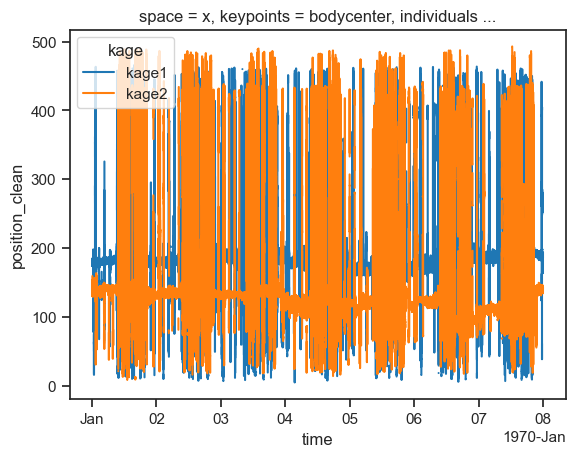

In [67]:
all_clean_positions.sel(space="x").plot.line(x="time", hue="kage")